In [5]:
from pytfa.io.json import load_json_model
from skimpy.io.yaml import load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.core.parameters import ParameterValues
from skimpy.utils.namespace import *
from skimpy.core.modifiers import *
from skimpy.io.yaml import load_yaml_model
from skimpy.core.reactor import Reactor
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.viz.plotting import timetrace_plot
from pytfa.io.json import load_json_model
from skimpy.io.yaml import load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations
from skimpy.core.parameters import load_parameter_population
from skimpy.simulations.reactor import make_batch_reactor
from skimpy.core.solution import ODESolutionPopulation
from skimpy.utils.namespace import *
from skimpy.viz.escher import animate_fluxes, plot_fluxes
import copy
from skimpy.io.yaml import export_to_yaml
from skimpy.analysis.ode.utils import make_flux_fun

import pandas as pd
import numpy as np

import seaborn as sns
import skimpy
import time
import matplotlib.pyplot as plt
import itertools
import matplotlib
import sys
sys.path.insert(1, '../functions/')

# benchmark functions
import simulation_functions as sf
import scenarios as sc
import visualizations as vis

#ML methods
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import  AdaBoostRegressor
from scipy.stats import linregress

In [6]:
def find_set_designs(comb_space,tcart,enz_names):
    """finds the training or test set designs in the combinatorial space
    Number of features has to be given
    - combinatorial space
    - cart of either the training scenario or the test set
    - enzyme names"""
    temp=0
    tset = pd.DataFrame()
    for design in tcart:
        sub=comb_space
        sub=sub.loc[sub['vmax_forward_Enzyme_A']==design[0]]
        sub=sub.loc[sub['vmax_forward_Enzyme_B']==design[1]]
        sub=sub.loc[sub['vmax_forward_Enzyme_C']==design[2]]
        sub=sub.loc[sub['vmax_forward_Enzyme_D']==design[3]]
        sub=sub.loc[sub['vmax_forward_Enzyme_E']==design[4]]
        sub=sub.loc[sub['vmax_forward_Enzyme_F']==design[5]]
        sub=sub.loc[sub['vmax_forward_Enzyme_G']==design[6]]
        tset=pd.concat([tset,sub])
    return tset,tcart

In [7]:
#Load simulations
comb_space=pd.read_csv("../data/combinatorial_space/combinatorial_space_pathway_A.csv")


#enzyme names and perturbation range
enz_names=["vmax_forward_Enzyme_A","vmax_forward_Enzyme_B","vmax_forward_Enzyme_C","vmax_forward_Enzyme_D",
           "vmax_forward_Enzyme_E","vmax_forward_Enzyme_F","vmax_forward_Enzyme_G"] #'vmax_forward_LDH_D',
perturb_range=[0.25,0.5,1,1.5,2,4]
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range)

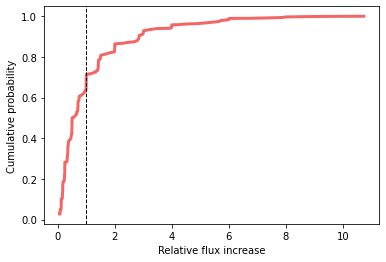

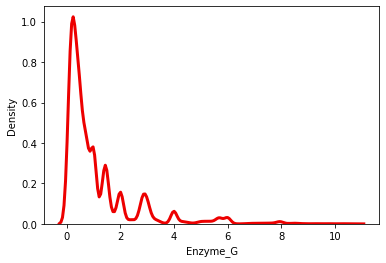

In [8]:
# evaluate the histogram
values, base = np.histogram(comb_space['Enzyme_G'], bins=10000)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
plt.plot(base[:-1], cumulative/len(comb_space['Enzyme_G']), c='#ED000099',linewidth=3)
plt.xlabel("Relative flux increase")
plt.ylabel("Cumulative probability")
plt.axvline(1,c="black",linestyle="--",linewidth=1)
plt.show()

# Density Plot and Histogram of all arrival delays
plot=sns.kdeplot(comb_space['Enzyme_G'], c='#ED000099',linewidth=3)

In [5]:
#Test whether it learns the landscape
designs,cart=sf.generate_perturbation_scheme(enz_names,perturb_range)

N_designs=50
#Define the scenario 
sc1_designs,sc1_cart=sc.scenario2(perturb_range,N_designs,enz_names)


#Retrieve the training set instances
training_scenario1,training_cart=find_set_designs(comb_space,sc1_cart,enz_names) 

train_X=training_scenario1[enz_names]
train_Y=training_scenario1['Enzyme_G']
test_X=comb_space[enz_names]
test_Y=comb_space['Enzyme_G']

regr_GradBoostReg=GradientBoostingRegressor()
regr_GradBoostReg.fit(train_X,train_Y)
predict_GradBoostReg=regr_GradBoostReg.predict(test_X)
slope, intercept, r_value, p_value, std_err = linregress(test_Y,predict_GradBoostReg)
score_GradBoost=r_value**2


#print("Stochastic Gradient Descent Regressor: "+str(regr_sgd.score(test_x,test_y)))
#rf
regr_rf = RandomForestRegressor()
regr_rf.fit(train_X, train_Y)
predict_rf=regr_rf.predict(test_X)
slope, intercept, r_value, p_value, std_err = linregress(test_Y,predict_rf)
score_rf=r_value**2


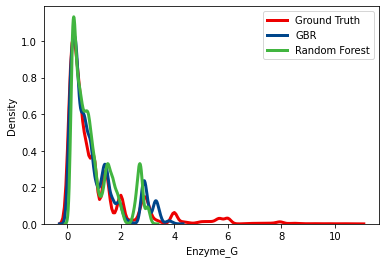

In [6]:
# Density Plot and Histogram of all arrival delays
plot=sns.kdeplot(comb_space['Enzyme_G'],c="#ED0000FF",label="Ground Truth",linewidth=3)
plot=sns.kdeplot(predict_GradBoostReg,c="#00468BFF",label="GBR",linewidth=3)
plot=sns.kdeplot(predict_rf,c="#42B540FF",label="Random Forest",linewidth=3)
plot.legend()

In [9]:
# Analyse for certain thresholds
#frequency_matrix=pd.DataFrame(np.zeros((len(enz_names),len(perturb_range))),index=enz_names,columns=perturb_range)


def generate_frequency_matrix(comb_space,threshold):
    frequency_matrix=np.zeros((len(enz_names),len(perturb_range)))
    
    # what are these blobs
    subset=comb_space.loc[comb_space['Enzyme_G']>threshold]
    subset=np.array(subset[enz_names])
    #counts number of remaining designs
    remaining_designs=len(subset)/np.shape(comb_space)[0]
    for i in range(np.shape(subset)[1]):
        for j in range(len(perturb_range)):
            frequency=len(np.where(subset[:,i]==perturb_range[j])[0])
            probability=frequency/np.shape(subset)[0]
            frequency_matrix[i,j]=probability
    frequency_matrix=pd.DataFrame(frequency_matrix,index=enz_names,columns=perturb_range)
    frequency_matrix=frequency_matrix.transpose()
    return frequency_matrix,remaining_designs


def scan_combinatorial_space(comb_space,step_size=0.005):
    largest_value=np.max(comb_space['Enzyme_G'])-0.00001
    threshold_range=np.arange(0.0001,largest_value,step_size)[::-1]
    a3d_freq_mat = np.zeros((len(perturb_range), len(enz_names), len(threshold_range)))
    
    remaining_design_list=[]
    #frequency_matrix=generate_frequency_matrix(comb_space,largest_value)
    for i,k in enumerate(threshold_range):
        frequency_matrix,remaining_designs=generate_frequency_matrix(comb_space,k)
        a3d_freq_mat[:,:,i]=frequency_matrix
        remaining_design_list.append(remaining_designs)
    return threshold_range,a3d_freq_mat, remaining_design_list

#def get_threshold_frequenc





In [12]:
threshold,matrix,remaining_designs=scan_combinatorial_space(comb_space)

#pred_comb_space=comb_space.copy()
#pred_comb_space['Enzyme_G']=predict_rf.copy()

#threshold,matrix_pred,remaining_designs_pred=scan_combinatorial_space(pred_comb_space)

(6, 7, 2147)


Text(0.5, 1.0, 'vmax_forward_Enzyme_A')

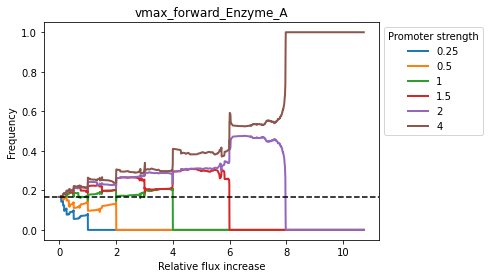

In [13]:
#response of enzyme A with 0.25 perturbation

A025=[]
A05=[]
A1=[]
A15=[]
A2=[]
A4=[]
print(np.shape(matrix))
#Rows are perturbation ranges (0.25,0.5,1,1.5,2,4)
#Columns are enzymes

enz=0
for i in range(np.shape(matrix)[2]):
    A025.append(matrix[0,enz,i])
    A05.append(matrix[1,enz,i])
    A1.append(matrix[2,enz,i])
    A15.append(matrix[3,enz,i])
    A2.append(matrix[4,enz,i])
    A4.append(matrix[5,enz,i])
    
    
plt.plot(threshold,A025,label="0.25",linewidth=2)
plt.plot(threshold,A05,label="0.5",linewidth=2)
plt.plot(threshold,A1,label="1",linewidth=2)
plt.plot(threshold,A15,label="1.5",linewidth=2)
plt.plot(threshold,A2,label="2",linewidth=2)
plt.plot(threshold,A4,label="4",linewidth=2)
#plt.plot(threshold,remaining_designs,c="black",label="Remaining designs space",linewidth=3,linestyle="--")
plt.axhline(1/6,c="black",linestyle="--")
plt.legend(title="Promoter strength",bbox_to_anchor=(1.,1))
plt.ylabel("Frequency")
plt.xlabel("Relative flux increase")
plt.title(str(enz_names[enz]))

## Area under the curve

In [15]:
from scipy.integrate import simpson
from scipy.stats import entropy
def get_feature_importance(matrix):
    """get the features that contribute most to increasing flux"""
    entropies=[]
    enzymes=np.arange(0,np.shape(matrix)[1])
    #loop over the 7 enzymes
    probability_matrix=np.zeros((np.shape(matrix)[0],np.shape(matrix)[1]))
    max_flux=np.max(comb_space['Enzyme_G'])
    for j in range(np.shape(matrix)[1]):
        enz_025=[]
        enz_05=[]
        enz_1=[]
        enz_15=[]
        enz_2=[]
        enz_4=[] 
        # loop over the flux threshold
        for i in range(np.shape(matrix)[2]):
            enz_025.append(matrix[0,enzymes[j],i])
            enz_05.append(matrix[1,enzymes[j],i])
            enz_1.append(matrix[2,enzymes[j],i])
            enz_15.append(matrix[3,enzymes[j],i])
            enz_2.append(matrix[4,enzymes[j],i])
            enz_4.append(matrix[5,enzymes[j],i])
        area_1 = simpson(enz_025, dx=0.005)/max_flux
        area_2 = simpson(enz_05, dx=0.005)/max_flux
        area_3 = simpson(enz_1, dx=0.005)/max_flux
        area_4 = simpson(enz_15, dx=0.005)/max_flux
        area_5 = simpson(enz_2, dx=0.005)/max_flux
        area_6 = simpson(enz_4, dx=0.005)/max_flux
        probability_distribution=[area_1,area_2,area_3,area_4,area_5,area_6]
        probability_matrix[:,j]=probability_distribution
        x=entropy(probability_distribution)
        entropies.append(x)
    enz_numbers=np.argsort(entropies)
    sorted_entropies=np.sort(entropies)
    return enz_numbers,sorted_entropies, probability_matrix
    
x,y,prob=get_feature_importance(matrix)

In [34]:
largest_value=np.max(comb_space['Enzyme_G'])-0.0001
print(largest_value)
# Make similar matrix for predicted
pred_comb_space=comb_space.copy()
pred_comb_space['Enzyme_G']=predict_rf.copy()

largest_value=np.max(pred_comb_space['Enzyme_G'])-0.0001
print(largest_value)

np.argsort(regr_rf.feature_importances_)[::-1]

10.734636628589437
3.4140521748808252


array([6, 0, 5, 4, 1, 2, 3])

<BarContainer object of 6 artists>

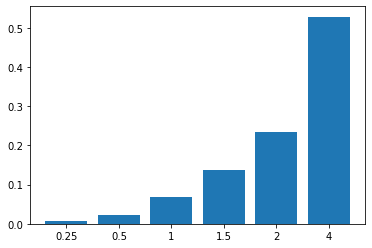

In [24]:
plt.bar(["0.25","0.5","1","1.5","2","4"],prob[:,0])

In [29]:
#
largest_value=np.max(comb_space['Enzyme_G'])-0.0001
print(largest_value)
##frequency_matrix=generate_frequency_matrix(comb_space,largest_value)

threshold_range=np.arange(0.0001,largest_value,0.01)[::-1]


value_list=[]

#make a function that follows the importance of features from the top of the hill 
def feature_importance(comb_space,enz_name,prom_strength):
    value_list=[]
    
    largest_value=np.max(comb_space['Enzyme_G'])-0.0001
    threshold_range=np.arange(0.0001,largest_value,0.005)[::-1]
    frequency_matrix=generate_frequency_matrix(comb_space,largest_value)
    x,y=np.where(frequency_matrix==1)
    print(x,y)
    for i in threshold_range:
        frequency_matrix=generate_frequency_matrix(comb_space,i)
        frequency_matrix=frequency_matrix[enz_name]
        frequency_matrix=frequency_matrix.loc[prom_strength]
        value_list.append(frequency_matrix)
    return value_list
        


#best design in set
frequency_G =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_G",prom_strength=0.25)
frequency_G_pred =feature_importance(pred_comb_space,enz_name="vmax_forward_Enzyme_G",prom_strength=0.25)

frequency_A =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_A",prom_strength=4)
frequency_A_pred =feature_importance(pred_comb_space,enz_name="vmax_forward_Enzyme_A",prom_strength=4)

frequency_B =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_B",prom_strength=4)
frequency_B_pred =feature_importance(pred_comb_space,enz_name="vmax_forward_Enzyme_B",prom_strength=4)

frequency_C =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_C",prom_strength=4)
frequency_C_pred =feature_importance(pred_comb_space,enz_name="vmax_forward_Enzyme_C",prom_strength=4)


frequency_D =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_D",prom_strength=4)
frequency_D_pred =feature_importance(pred_comb_space,enz_name="vmax_forward_Enzyme_D",prom_strength=4)

frequency_E =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_E",prom_strength=4)
frequency_E_pred =feature_importance(pred_comb_space,enz_name="vmax_forward_Enzyme_E",prom_strength=4)

frequency_F =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_F",prom_strength=4)
frequency_F_pred =feature_importance(pred_comb_space,enz_name="vmax_forward_Enzyme_F",prom_strength=4)

#frequency_G =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_G",prom_strength=0.25)
#frequency_G_pred =feature_importance(pred_comb_space,enz_name="vmax_forward_Enzyme_G",prom_strength=0.25)
#frequency_A_low =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_A",prom_strength=4.0)
#frequency_B_low =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_B",prom_strength=4.0)
#frequency_C_low =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_C",prom_strength=4.0)
#frequency_D_low =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_D",prom_strength=4.0)
#frequency_E_low =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_E",prom_strength=4.0)
#frequency_F_low =feature_importance(comb_space,enz_name="vmax_forward_Enzyme_F",prom_strength=4.0)



10.734636628589437


ValueError: not enough values to unpack (expected 2, got 1)

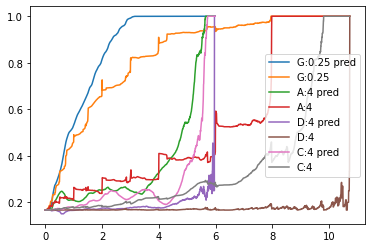

In [10]:
#best design set
largest_value1=np.max(comb_space['Enzyme_G'])-0.0001
threshold_range1=np.arange(0.0001,largest_value1,0.005)[::-1]
largest_value2=np.max(pred_comb_space['Enzyme_G'])-0.0001
threshold_range2=np.arange(0.0001,largest_value2,0.005)[::-1]

ax = plt.subplot(111)
plt.plot(threshold_range2,frequency_G_pred,label="G:0.25 pred")
plt.plot(threshold_range1,frequency_G,label="G:0.25")

plt.plot(threshold_range2,frequency_A_pred,label="A:4 pred")
plt.plot(threshold_range1,frequency_A,label="A:4")


plt.plot(threshold_range2,frequency_D_pred,label="D:4 pred")
plt.plot(threshold_range1,frequency_D,label="D:4")

plt.plot(threshold_range2,frequency_E_pred,label="C:4 pred")
plt.plot(threshold_range1,frequency_E,label="C:4")

plt.legend()


In [31]:
np.argsort(regr_rf.feature_importances_)[::-1]

#Order: Enzyme G, Enzyme A, Enzyme C, Enzyme E, Enzyme B, Enzyme F, Enzyme D 

array([6, 0, 5, 4, 1, 2, 3])

# Scenario